In [261]:
# To ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# Import the libraries to handle the np array and pandas dataframe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

# Import py files
import acquire, prepare, explore

import psutil
from tqdm.notebook import tqdm
import gc

from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, roc_auc_score

### Acquire and Prepare the Train/Validate/Test Dataset

In [2]:
%%time

# Define the data types
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16", 
    "content_type_id": "boolean", 
    "task_container_id": "int16",
    "user_answer": "int8", 
    "answered_correctly": "int8", 
    "prior_question_elapsed_time": "float32"   
}

# Load train/validate/test
df_train = pd.read_csv("../Riiid-Project/sampled_trainset.csv", index_col=0, dtype=dtypes)
df_validate = pd.read_csv("../Riiid-Project/validate.csv", index_col=0, dtype=dtypes)
df_test = pd.read_csv("../Riiid-Project/test.csv", index_col=0, dtype=dtypes)

CPU times: user 44 s, sys: 5.09 s, total: 49.1 s
Wall time: 50.1 s


In [3]:
%%time

# Define the data types
dtypes = {
    "question_id": "int16", 
    "bundle_id": "int16",
    "correct_answer": "int8", 
    "part": "int8", 
    "tags": "object", 
    "tag_count": "int8"    
    }

# Load questions dataset
df_ques = pd.read_csv('questions_with_tag_counts.csv', index_col=0, dtype=dtypes)

CPU times: user 8.13 ms, sys: 6.46 ms, total: 14.6 ms
Wall time: 14.8 ms


In [6]:
# Print the information of df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20964878 entries, 0 to 13083813322
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   content_type_id                 boolean
 3   task_container_id               int16  
 4   user_answer                     int8   
 5   answered_correctly              int8   
 6   prior_question_elapsed_time     float32
 7   prior_question_had_explanation  object 
 8   lecture_id                      float64
 9   tag                             float64
 10  lecture_part                    float64
 11  type_of                         object 
 12  question_id                     float64
 13  bundle_id                       float64
 14  correct_answer                  float64
 15  question_part                   float64
 16  tags                            object 
dtypes: boolean(1), float32

In [7]:
%%time

# Drop columns that are not needed

cols = ['lecture_id', 'tag', 'lecture_part','type_of', 'question_id', 'bundle_id', 
        'correct_answer', 'question_part', 'tags', 'content_type_id', 'user_answer']

df_train.drop(columns=cols, inplace=True)
df_validate.drop(columns=cols, inplace=True)
df_test.drop(columns=cols, inplace=True)

CPU times: user 673 ms, sys: 1.56 s, total: 2.23 s
Wall time: 2.82 s


In [8]:
# Print the information of df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20964878 entries, 0 to 13083813322
Data columns (total 6 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  object 
dtypes: float32(1), int16(2), int32(1), int8(1), object(1)
memory usage: 579.8+ MB


In [9]:
# Print the information of df_ques
df_ques.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13523 entries, 0 to 13522
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int16 
 1   bundle_id       13523 non-null  int16 
 2   correct_answer  13523 non-null  int8  
 3   part            13523 non-null  int8  
 4   tags            13522 non-null  object
 5   tag_count       13523 non-null  int8  
dtypes: int16(2), int8(3), object(1)
memory usage: 303.7+ KB


In [10]:
%%time
# Drop lecture rows

mask = (df_train.answered_correctly != -1)
df_train = df_train[mask]

mask = (df_validate.answered_correctly != -1)
df_validate = df_validate[mask]

mask = (df_test.answered_correctly != -1)
df_test = df_test[mask]

CPU times: user 1.08 s, sys: 611 ms, total: 1.69 s
Wall time: 1.89 s


In [11]:
%%time

# Merge df_train and df_ques
df_train = df_train.merge(df_ques, how='left', left_on='content_id', right_on='question_id')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 12 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  object 
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
dtypes: float32(1), int16(4), int32(1), int8(4), object(2)
memory usage: 862.5+ MB
CPU times: user 3.07 s, sys: 1.01 s, total: 4.08 s
Wall time: 4.1 s


In [12]:
# Check the nulls in df_train
df_train.isnull().sum(axis=0)

user_id                               0
content_id                            0
task_container_id                     0
answered_correctly                    0
prior_question_elapsed_time       99720
prior_question_had_explanation    99720
question_id                           0
bundle_id                             0
correct_answer                        0
part                                  0
tags                                  1
tag_count                             0
dtype: int64

In [13]:
%%time

# Merge df_train and df_ques
df_validate = df_validate.merge(df_ques, how='left', left_on='content_id', right_on='question_id')
df_test = df_test.merge(df_ques, how='left', left_on='content_id', right_on='question_id')

CPU times: user 647 ms, sys: 146 ms, total: 792 ms
Wall time: 795 ms


In [14]:
# Check the nulls in df_validate
df_validate.isnull().sum(axis=0)

user_id                           0
content_id                        0
task_container_id                 0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
question_id                       0
bundle_id                         0
correct_answer                    0
part                              0
tags                              0
tag_count                         0
dtype: int64

In [15]:
# Check the nulls in df_test
df_test.isnull().sum(axis=0)

user_id                           0
content_id                        0
task_container_id                 0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
question_id                       0
bundle_id                         0
correct_answer                    0
part                              0
tags                              0
tag_count                         0
dtype: int64

In [16]:
%%time

# Fill the missing value in col `prior_question_elapsed_time` with 0
df_train.prior_question_elapsed_time.fillna(0, inplace=True)

# Fill the missing value in col `prior_question_had_explanation` with False
df_train.prior_question_had_explanation.fillna(False, inplace=True)

# Print the information of df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 12 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
dtypes: bool(1), float32(1), int16(4), int32(1), int8(4), object(1)
memory usage: 725.3+ MB
CPU times: user 1.24 s, sys: 22.4 ms, total: 1.27 s
Wall time: 1.27 s


In [17]:
# Check the nulls in df_train
df_train.isnull().sum(axis=0)

user_id                           0
content_id                        0
task_container_id                 0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
question_id                       0
bundle_id                         0
correct_answer                    0
part                              0
tags                              1
tag_count                         0
dtype: int64

### Add new features - user_accuracy

In [25]:
def compute_user_acc(df_train): 
    
    # Compute the accuracy when a user answer an question
    user_accuracy = df_train.groupby('user_id').answered_correctly.mean().round(3).to_frame().reset_index()

    # Rename the 3rd column
    user_accuracy.rename(columns={'answered_correctly': 'user_acc'}, inplace=True)
    
    # Cast the 3rd column to float32
    user_accuracy['user_acc'] = user_accuracy['user_acc'].astype("float32")

    return user_accuracy

In [26]:
%%time
# Compute the user_accuracy

user_accuracy = compute_user_acc(df_train)
user_accuracy.head(2)

CPU times: user 429 ms, sys: 238 ms, total: 666 ms
Wall time: 665 ms


,user_id,user_acc
0,24600,0.275
1,128919,0.333


In [27]:
%%time
# Concat user_accuracy to the df_train

df_train = df_train.merge(user_accuracy, how='left', on='user_id')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 13 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_acc                        float32
dtypes: bool(1), float32(2), int16(4), int32(1), int8(4), object(1)
memory usage: 803.7+ MB
CPU times: user 2.57 s, sys: 925 ms, total: 3.49 s
Wall time: 3.5 s


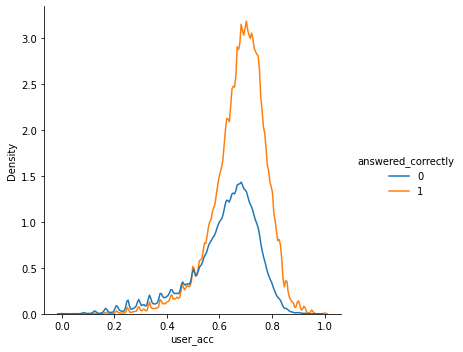

CPU times: user 1min 2s, sys: 10.8 s, total: 1min 12s
Wall time: 1min 10s


In [29]:
%%time
# Plot the distribution of values in column user_part_acc

sns.displot(data=df_train, x='user_acc', hue='answered_correctly', kind='kde')
plt.show()

In [30]:
%%time
# Concat user_accuracy to the df_validate

df_validate = df_validate.merge(user_accuracy, how='left', on='user_id')

# Check the missing values
df_validate.isnull().sum(axis=0)

CPU times: user 451 ms, sys: 102 ms, total: 553 ms
Wall time: 553 ms


user_id                           0
content_id                        0
task_container_id                 0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
question_id                       0
bundle_id                         0
correct_answer                    0
part                              0
tags                              0
tag_count                         0
user_acc                          0
dtype: int64

In [31]:
%%time
# Concat user_accuracy to the df_test

df_test = df_test.merge(user_accuracy, how='left', on='user_id')

# Check the missing values
df_test.isnull().sum(axis=0)

CPU times: user 468 ms, sys: 111 ms, total: 580 ms
Wall time: 579 ms


user_id                           0
content_id                        0
task_container_id                 0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
question_id                       0
bundle_id                         0
correct_answer                    0
part                              0
tags                              0
tag_count                         0
user_acc                          0
dtype: int64

### Add new feature - bundle_accuracy

In [142]:
def compute_bundle_acc(df_train): 
    
    # Compute the accuracy when a user answer an question
    bundle_accuracy = df_train.groupby('bundle_id').answered_correctly.mean().round(3).to_frame().reset_index()

    # Rename the 3rd column
    bundle_accuracy.rename(columns={'answered_correctly': 'bundle_acc'}, inplace=True)
    
    # Cast the 3rd column to float32
    bundle_accuracy['bundle_acc'] = bundle_accuracy['bundle_acc'].astype("float32")

    return bundle_accuracy

In [143]:
%%time
# Compute the bundle_accuracy

bundle_accuracy = compute_bundle_acc(df_train)
bundle_accuracy.head(2)

CPU times: user 490 ms, sys: 239 ms, total: 728 ms
Wall time: 727 ms


,bundle_id,bundle_acc
0,0,0.913
1,1,0.896


In [144]:
%%time
# Concat bundle_accuracy to the df_train

df_train = df_train.merge(bundle_accuracy, how='left', on='bundle_id')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 18 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_acc                        float32
 13  user_tags_acc                   float32
 14  user_part_acc                   float32
 15  user_tagcount_acc               float32
 16  ques_acc                        float32
 17  bundle_acc               

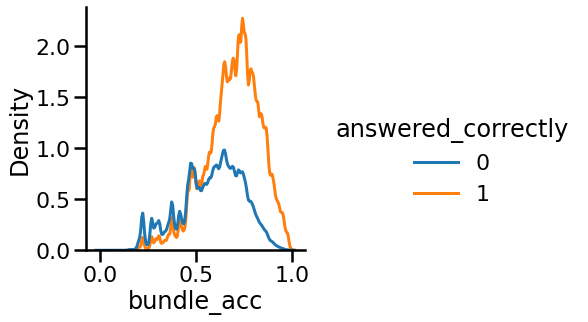

CPU times: user 1min 14s, sys: 13.4 s, total: 1min 28s
Wall time: 1min 26s


In [145]:
%%time
# Plot the distribution of values in column bundle_acc

sns.displot(data=df_train, x='bundle_acc', hue='answered_correctly', kind='kde')
plt.show()

In [146]:
%%time
# Concat bundle_accuracy to the df_validate

df_validate = df_validate.merge(bundle_accuracy, how='left', on='bundle_id')

# Check the missing values
df_validate.isnull().sum(axis=0)

CPU times: user 570 ms, sys: 296 ms, total: 866 ms
Wall time: 977 ms


user_id                                0
content_id                             0
task_container_id                      0
answered_correctly                     0
prior_question_elapsed_time            0
prior_question_had_explanation         0
question_id                            0
bundle_id                              0
correct_answer                         0
part                                   0
tags                                   0
tag_count                              0
user_acc                               0
user_tags_acc                     757773
user_part_acc                      41473
user_tagcount_acc                  14165
ques_acc                               3
bundle_acc                             3
dtype: int64

In [147]:
%%time
# Concat bundle_accuracy to the df_test

df_test = df_test.merge(bundle_accuracy, how='left', on='bundle_id')

# Check the missing values
df_test.isnull().sum(axis=0)

CPU times: user 631 ms, sys: 353 ms, total: 984 ms
Wall time: 1.11 s


user_id                                0
content_id                             0
task_container_id                      0
answered_correctly                     0
prior_question_elapsed_time            0
prior_question_had_explanation         0
question_id                            0
bundle_id                              0
correct_answer                         0
part                                   0
tags                                   0
tag_count                              0
user_acc                               0
user_tags_acc                     831523
user_part_acc                      90722
user_tagcount_acc                  23591
ques_acc                               1
bundle_acc                             1
dtype: int64

### Add new feature - part_accuracy

In [242]:
def compute_part_acc(df_train): 
    
    # Compute the accuracy when a user answer an question
    part_accuracy = df_train.groupby('part').answered_correctly.mean().round(3).to_frame().reset_index()

    # Rename the 3rd column
    part_accuracy.rename(columns={'answered_correctly': 'part_acc'}, inplace=True)
    
    # Cast the 3rd column to float32
    part_accuracy['part_acc'] = part_accuracy['part_acc'].astype("float32")

    return part_accuracy

In [243]:
%%time
# Compute the part_accuracy

part_accuracy = compute_part_acc(df_train)
part_accuracy.head(2)

CPU times: user 411 ms, sys: 236 ms, total: 647 ms
Wall time: 646 ms


,part,part_acc
0,1,0.743
1,2,0.708


In [244]:
%%time
# Concat part_accuracy to the df_train

df_train = df_train.merge(part_accuracy, how='left', on='part')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 19 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_acc                        float32
 13  user_tags_acc                   float32
 14  user_part_acc                   float32
 15  user_tagcount_acc               float32
 16  ques_acc                        float32
 17  bundle_acc               

In [245]:
%%time
# Concat bundle_accuracy to the df_validate

df_validate = df_validate.merge(part_accuracy, how='left', on='part')
df_test = df_test.merge(part_accuracy, how='left', on='part')

CPU times: user 903 ms, sys: 791 ms, total: 1.69 s
Wall time: 2.01 s


### Add new feature - task_accuracy

In [306]:
def compute_task_acc(df_train): 
    
    # Compute the accuracy when a user answer an question
    task_accuracy = df_train.groupby('task_container_id').answered_correctly.mean().round(3).to_frame().reset_index()

    # Rename the 3rd column
    task_accuracy.rename(columns={'answered_correctly': 'task_acc'}, inplace=True)
    
    # Cast the 3rd column to float32
    task_accuracy['task_acc'] = task_accuracy['task_acc'].astype("float32")

    return task_accuracy

In [307]:
%%time
# Compute the task_accuracy

task_accuracy = compute_task_acc(df_train)
task_accuracy.head(2)

CPU times: user 466 ms, sys: 234 ms, total: 699 ms
Wall time: 698 ms


,task_container_id,task_acc
0,0,0.681
1,1,0.526


In [308]:
%%time
# Concat task_accuracy to the df_train

df_train = df_train.merge(task_accuracy, how='left', on='task_container_id')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 20 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_acc                        float32
 13  user_tags_acc                   float32
 14  user_part_acc                   float32
 15  user_tagcount_acc               float32
 16  ques_acc                        float32
 17  bundle_acc               

In [309]:
%%time
# Concat task_accuracy to the df_validate and df_test

df_validate = df_validate.merge(task_accuracy, how='left', on='task_container_id')
df_test = df_test.merge(task_accuracy, how='left', on='task_container_id')

CPU times: user 925 ms, sys: 788 ms, total: 1.71 s
Wall time: 1.96 s


### Add new features - user_ques_accuracy

In [338]:
%%time
# Compute the user_ques_accuracy

user_ques_accuracy = explore.compute_user_ques_acc(df_train)
user_ques_accuracy.head(2)

CPU times: user 7.04 s, sys: 2.96 s, total: 10 s
Wall time: 10.4 s


,user_id,content_id,user_ques_acc
0,24600,175,1.0
1,24600,1278,1.0


In [339]:
%%time
# Concat the user_ques_acc to the df_train

df_train = df_train.merge(user_ques_accuracy, how='left', 
                          left_on = ['user_id', 'content_id'], 
                          right_on = ['user_id', 'content_id'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 21 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_acc                        float32
 13  user_tags_acc                   float32
 14  user_part_acc                   float32
 15  user_tagcount_acc               float32
 16  ques_acc                        float32
 17  bundle_acc               

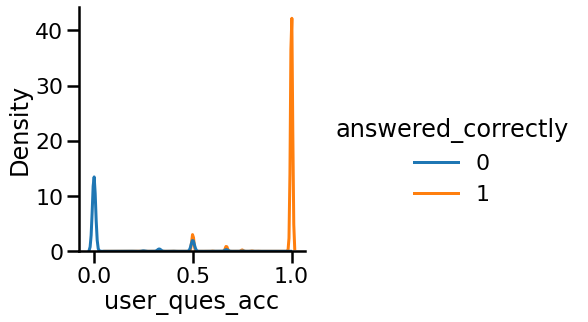

CPU times: user 1min 4s, sys: 11.4 s, total: 1min 15s
Wall time: 1min 13s


In [340]:
%%time
# Plot the distribution of values in column user_ques_acc

sns.displot(data=df_train, x='user_ques_acc', hue='answered_correctly', kind='kde')
plt.show()

In [341]:
%%time
# Concat the user_ques_acc to the df_validate

df_validate = df_validate.merge(user_ques_accuracy, how='left', 
                                left_on = ['user_id', 'content_id'], 
                                right_on = ['user_id', 'content_id'])

# Check the missing values
df_validate.isnull().sum(axis=0)

CPU times: user 5.01 s, sys: 1.84 s, total: 6.84 s
Wall time: 7.08 s


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
question_id                             0
bundle_id                               0
correct_answer                          0
part                                    0
tags                                    0
tag_count                               0
user_acc                                0
user_tags_acc                      757773
user_part_acc                       41473
user_tagcount_acc                   14165
ques_acc                                3
bundle_acc                              3
part_acc                                0
task_acc                             3545
user_ques_acc                     2193284
dtype: int64

In [36]:
# What percent of the values in column user_ques-acc are missing? 
print(f"{round((2193284*100/df_validate.shape[0]),2)}% of the values in column user_ques_acc is missing")

86.32% of the values in column user_ques_acc is missing


In [342]:
%%time
# Concat the user_ques_acc to the df_test

df_test = df_test.merge(user_ques_accuracy, how='left', 
                        left_on = ['user_id', 'content_id'], 
                        right_on = ['user_id', 'content_id'])

# Check the missing values
df_test.isnull().sum(axis=0)

CPU times: user 5.04 s, sys: 1.76 s, total: 6.8 s
Wall time: 7 s


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
question_id                             0
bundle_id                               0
correct_answer                          0
part                                    0
tags                                    0
tag_count                               0
user_acc                                0
user_tags_acc                      831523
user_part_acc                       90722
user_tagcount_acc                   23591
ques_acc                                1
bundle_acc                              1
part_acc                                0
task_acc                            43053
user_ques_acc                     2312506
dtype: int64

In [66]:
# What percent of the values in the column user_ques_acc are missing?
print(f"{round((2312506*100/df_test.shape[0]),2)}% of the values in column user_ques_acc is missing")

87.44% of the values in column user_ques_acc is missing


**Takeaways**: About 87% of the questions in the validate and test dataset are new to the users. 

### Add new features - user_bundle_accuracy

In [56]:
%%time
# Compute the user_bundle_accuracy

user_bundle_accuracy = explore.compute_user_bundle_acc(df_train)
user_bundle_accuracy.head(2)

CPU times: user 5.76 s, sys: 2.13 s, total: 7.89 s
Wall time: 8.06 s


,user_id,bundle_id,user_bundle_acc
0,24600,175,1.0
1,24600,1278,1.0


In [58]:
%%time
# Concat the user_bundle_acc to the df_train

df_train = df_train.merge(user_bundle_accuracy, how='left', 
                          left_on = ['user_id', 'bundle_id'], 
                          right_on = ['user_id', 'bundle_id'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 14 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_ques_acc                   float16
 13  user_bundle_acc                 float16
dtypes: bool(1), float16(2), float32(1), int16(4), int32(1), int8(4), object(1)
memory usage: 803.7+ MB
CPU times: user 7.61 s, sys: 2.79 s, total: 10.4 s
Wall time:

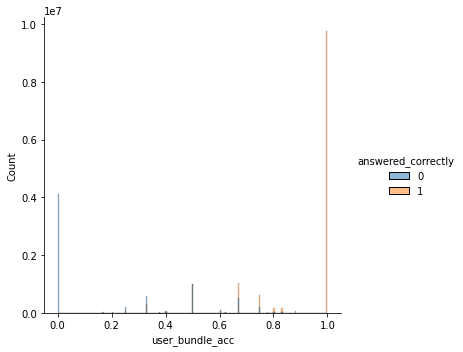

CPU times: user 5.79 s, sys: 1.1 s, total: 6.89 s
Wall time: 6.81 s


In [76]:
%%time
# Plot the distribution of values in column user_bundle_acc

sns.displot(data=df_train, x='user_bundle_acc', hue='answered_correctly')
plt.show()

In [65]:
%%time
# Concat the user_bundle_acc to the df_validate

df_validate = df_validate.merge(user_bundle_accuracy, how='left', 
                                left_on = ['user_id', 'bundle_id'], 
                                right_on = ['user_id', 'bundle_id'])

# Check the missing values
df_validate.isnull().sum(axis=0)

CPU times: user 4.05 s, sys: 1.52 s, total: 5.57 s
Wall time: 5.74 s


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2193284
question_id                             0
bundle_id                               0
correct_answer                          0
part                                    0
tags                                    0
tag_count                               0
user_bundle_acc                   2147909
dtype: int64

In [67]:
# What percent of the values in column user_bundle_acc are missing? 
print(f"{round((2147909*100/df_validate.shape[0]),2)}% of the values in column user_bundle_acc is missing")

84.53% of the values in column user_bundle_acc is missing


In [69]:
%%time
# Concat the user_bundle_acc to the df_test

df_test = df_test.merge(user_bundle_accuracy, how='left', 
                        left_on = ['user_id', 'bundle_id'], 
                        right_on = ['user_id', 'bundle_id'])

# Check the missing values
df_test.isnull().sum(axis=0)

CPU times: user 4.17 s, sys: 1.24 s, total: 5.41 s
Wall time: 5.46 s


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2312506
question_id                             0
bundle_id                               0
correct_answer                          0
part                                    0
tags                                    0
tag_count                               0
user_bundle_acc                   2312095
dtype: int64

In [70]:
# What percent of the values in column user_bundle_acc are missing? 
print(f"{round((2312095*100/df_test.shape[0]),2)}% of the values in column user_bundle_acc is missing")

87.43% of the values in column user_bundle_acc is missing


**Takeaways**: About 86% of the bundles in the validate and test dataset are new to the users. 

### Add new features - user_tags_accuracy

In [32]:
%%time
# Compute the user_tags_accuracy

user_tags_accuracy = explore.compute_user_tags_acc(df_train)
user_tags_accuracy.head(2)

CPU times: user 4.47 s, sys: 1.44 s, total: 5.92 s
Wall time: 6.02 s


,user_id,tags,user_tags_acc
0,24600,1,0.0
1,24600,10 94 92,0.0


In [33]:
%%time
# Concat the user_part_acc to the df_train

df_train = df_train.merge(user_tags_accuracy, how='left', 
                          left_on = ['user_id', 'tags'], 
                          right_on = ['user_id', 'tags'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 14 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_acc                        float32
 13  user_tags_acc                   float32
dtypes: bool(1), float32(3), int16(4), int32(1), int8(4), object(1)
memory usage: 882.1+ MB
CPU times: user 6.26 s, sys: 2.12 s, total: 8.37 s
Wall time: 8.43 s


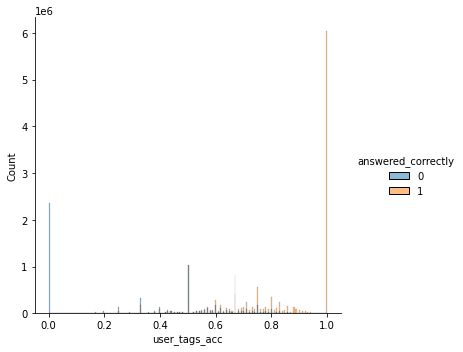

CPU times: user 6.68 s, sys: 1.46 s, total: 8.14 s
Wall time: 8.19 s


In [79]:
%%time
# Plot the distribution of values in column user_tags_acc

sns.displot(data=df_train, x='user_tags_acc', hue='answered_correctly')
plt.show()

In [34]:
%%time
# Concat the user_tags_acc to the df_validate

df_validate = df_validate.merge(user_tags_accuracy, how='left', 
                                left_on = ['user_id', 'tags'], 
                                right_on = ['user_id', 'tags'])

# Check the missing values
df_validate.isnull().sum(axis=0)

CPU times: user 2.53 s, sys: 722 ms, total: 3.25 s
Wall time: 3.27 s


user_id                                0
content_id                             0
task_container_id                      0
answered_correctly                     0
prior_question_elapsed_time            0
prior_question_had_explanation         0
question_id                            0
bundle_id                              0
correct_answer                         0
part                                   0
tags                                   0
tag_count                              0
user_acc                               0
user_tags_acc                     757773
dtype: int64

In [83]:
# What percent of the values in column user_tags_acc are missing? 
print(f"{round((757773*100/df_validate.shape[0]),2)}% of the values in column user_tags_acc is missing")

29.82% of the values in column user_tags_acc is missing


In [35]:
%%time
# Concat the user_tags_acc to the df_test

df_test = df_test.merge(user_tags_accuracy, how='left', 
                        left_on = ['user_id', 'tags'], 
                        right_on = ['user_id', 'tags'])

# Check the missing values
df_test.isnull().sum(axis=0)

CPU times: user 2.59 s, sys: 807 ms, total: 3.4 s
Wall time: 3.41 s


user_id                                0
content_id                             0
task_container_id                      0
answered_correctly                     0
prior_question_elapsed_time            0
prior_question_had_explanation         0
question_id                            0
bundle_id                              0
correct_answer                         0
part                                   0
tags                                   0
tag_count                              0
user_acc                               0
user_tags_acc                     831523
dtype: int64

In [85]:
# What percent of the values in column user_tags_acc are missing? 
print(f"{round((831523*100/df_test.shape[0]),2)}% of the values in column user_tags_acc is missing")

31.44% of the values in column user_tags_acc is missing


**Takeaways**: About 30% of the tags in the validate and test dataset are new to the users. 

### Add new features - user_part_accuracy

In [36]:
%%time
# Compute the user_part_accuracy

user_part_accuracy = explore.compute_user_part_acc(df_train)
user_part_accuracy.head(2)

CPU times: user 1.03 s, sys: 580 ms, total: 1.61 s
Wall time: 1.61 s


,user_id,part,user_part_acc
0,24600,1,0.67
1,24600,2,1.00


In [37]:
%%time
# Concat the user_part_acc to the df_train

df_train = df_train.merge(user_part_accuracy, how='left', 
                          left_on = ['user_id', 'part'], 
                          right_on = ['user_id', 'part'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 15 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_acc                        float32
 13  user_tags_acc                   float32
 14  user_part_acc                   float32
dtypes: bool(1), float32(4), int16(4), int32(1), int8(4), object(1)
memory usage: 960.5+ MB
CPU times: user 3.23 s, sys:

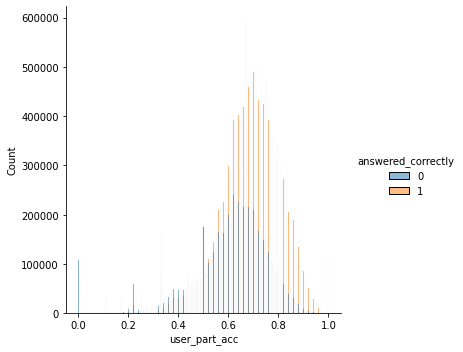

CPU times: user 7.87 s, sys: 1.13 s, total: 9 s
Wall time: 8.9 s


In [93]:
%%time
# Plot the distribution of values in column user_part_acc

sns.displot(data=df_train, x='user_part_acc', hue='answered_correctly')
plt.show()

In [38]:
%%time
# Concat the user_part_acc to the df_validate

df_validate = df_validate.merge(user_part_accuracy, how='left', 
                                left_on = ['user_id', 'part'], 
                                right_on = ['user_id', 'part'])

# Check the missing values
df_validate.isnull().sum(axis=0)

CPU times: user 564 ms, sys: 170 ms, total: 734 ms
Wall time: 735 ms


user_id                                0
content_id                             0
task_container_id                      0
answered_correctly                     0
prior_question_elapsed_time            0
prior_question_had_explanation         0
question_id                            0
bundle_id                              0
correct_answer                         0
part                                   0
tags                                   0
tag_count                              0
user_acc                               0
user_tags_acc                     757773
user_part_acc                      41473
dtype: int64

In [95]:
# What percent of the values in column user_part_acc are missing? 
print(f"{round((41473*100/df_validate.shape[0]),2)}% of the values in column user_part_acc is missing")

1.63% of the values in column user_part_acc is missing


In [39]:
%%time
# Concat the user_part_acc to the df_test

df_test = df_test.merge(user_part_accuracy, how='left', 
                        left_on = ['user_id', 'part'], 
                        right_on = ['user_id', 'part'])

# Check the missing values
df_test.isnull().sum(axis=0)

CPU times: user 577 ms, sys: 134 ms, total: 711 ms
Wall time: 711 ms


user_id                                0
content_id                             0
task_container_id                      0
answered_correctly                     0
prior_question_elapsed_time            0
prior_question_had_explanation         0
question_id                            0
bundle_id                              0
correct_answer                         0
part                                   0
tags                                   0
tag_count                              0
user_acc                               0
user_tags_acc                     831523
user_part_acc                      90722
dtype: int64

In [98]:
# What percent of the values in column user_part_acc are missing? 
print(f"{round((90722*100/df_test.shape[0]),2)}% of the values in column user_part_acc is missing")

3.43% of the values in column user_part_acc is missing


**Takeaways**: 2% of the users in the validate and test dataset are going to answer the questions in the new parts. 

### Add new feature - user_tagcount_accuracy

In [40]:
%%time
# Compute the user_tagcount_accuracy

user_tagcount_accuracy = explore.compute_user_tagcount_acc(df_train)
user_tagcount_accuracy.head(2)

CPU times: user 1.02 s, sys: 587 ms, total: 1.61 s
Wall time: 1.61 s


,user_id,tag_count,user_tagcount_acc
0,24600,1,0.30
1,24600,3,0.17


In [41]:
%%time
# Concat the user_tagcount_acc to the df_train

df_train = df_train.merge(user_tagcount_accuracy, how='left', 
                          left_on = ['user_id', 'tag_count'], 
                          right_on = ['user_id', 'tag_count'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 16 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_acc                        float32
 13  user_tags_acc                   float32
 14  user_part_acc                   float32
 15  user_tagcount_acc               float32
dtypes: bool(1), float32(5), int16(4), int32(1), int8(4), object(1)
memory 

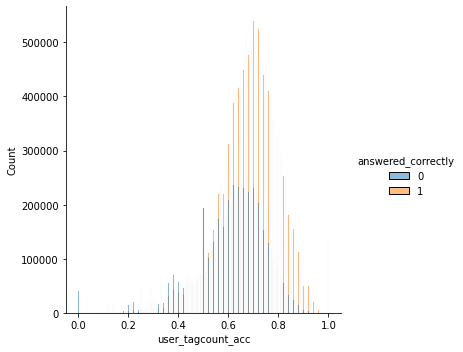

CPU times: user 8.27 s, sys: 1.11 s, total: 9.38 s
Wall time: 9.29 s


In [102]:
%%time
# Plot the distribution of values in column user_part_acc

sns.displot(data=df_train, x='user_tagcount_acc', hue='answered_correctly')
plt.show()

In [42]:
%%time
# Concat the user_tagcount_acc to the df_validate

df_validate = df_validate.merge(user_tagcount_accuracy, how='left', 
                                left_on = ['user_id', 'tag_count'], 
                                right_on = ['user_id', 'tag_count'])

# Check the missing values
df_validate.isnull().sum(axis=0)

CPU times: user 575 ms, sys: 167 ms, total: 742 ms
Wall time: 742 ms


user_id                                0
content_id                             0
task_container_id                      0
answered_correctly                     0
prior_question_elapsed_time            0
prior_question_had_explanation         0
question_id                            0
bundle_id                              0
correct_answer                         0
part                                   0
tags                                   0
tag_count                              0
user_acc                               0
user_tags_acc                     757773
user_part_acc                      41473
user_tagcount_acc                  14165
dtype: int64

In [105]:
# What percent of the values in column user_tagcount_acc are missing? 
print(f"{round((14165*100/df_validate.shape[0]),2)}% of the values in column user_tagcount_acc is missing")

0.56% of the values in column user_tagcount_acc is missing


In [43]:
%%time
# Concat the user_tagcount_acc to the df_test

df_test = df_test.merge(user_tagcount_accuracy, how='left', 
                        left_on = ['user_id', 'tag_count'], 
                        right_on = ['user_id', 'tag_count'])

# Check the missing values
df_test.isnull().sum(axis=0)

CPU times: user 603 ms, sys: 148 ms, total: 751 ms
Wall time: 752 ms


user_id                                0
content_id                             0
task_container_id                      0
answered_correctly                     0
prior_question_elapsed_time            0
prior_question_had_explanation         0
question_id                            0
bundle_id                              0
correct_answer                         0
part                                   0
tags                                   0
tag_count                              0
user_acc                               0
user_tags_acc                     831523
user_part_acc                      90722
user_tagcount_acc                  23591
dtype: int64

In [107]:
# What percent of the values in column user_tagcount_acc are missing? 
print(f"{round((23591*100/df_test.shape[0]),2)}% of the values in column user_tagcount_acc is missing")

0.89% of the values in column user_tagcount_acc is missing


**Takeaways:** Less than 1% of the users in the validate and test dataset are going to answer the questions in the a new tagcount.

### Create new feature - question accuracy

In [44]:
%%time
# Compute the ques_accuracy

ques_accuracy = explore.compute_ques_acc(df_train)
ques_accuracy.head(2)

CPU times: user 531 ms, sys: 247 ms, total: 778 ms
Wall time: 779 ms


,ques_acc
content_id,
0,0.91
1,0.90


In [45]:
%%time
# Concat ques_accuracy to the df_train

df_train = df_train.merge(ques_accuracy, how='left', on='content_id')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_acc                        float32
 13  user_tags_acc                   float32
 14  user_part_acc                   float32
 15  user_tagcount_acc               float32
 16  ques_acc                        float32
dtypes: bool(1), float32(6), i

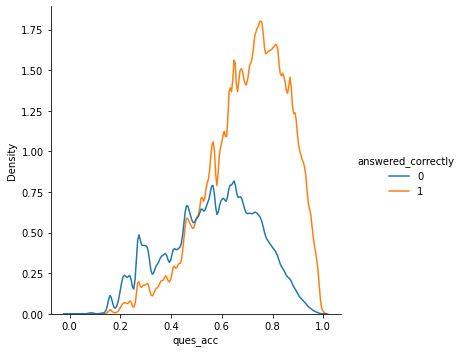

CPU times: user 1min 16s, sys: 12.5 s, total: 1min 28s
Wall time: 1min 27s


In [60]:
%%time
# Plot the distribution of values in column user_part_acc

sns.displot(data=df_train, x='ques_acc', hue='answered_correctly', kind='kde')
plt.show()

In [46]:
%%time
# Concat ques_accuracy to the df_validate

df_validate = df_validate.merge(ques_accuracy, how='left', on='content_id')

# Check the missing values
df_validate.isnull().sum(axis=0)

CPU times: user 578 ms, sys: 162 ms, total: 740 ms
Wall time: 741 ms


user_id                                0
content_id                             0
task_container_id                      0
answered_correctly                     0
prior_question_elapsed_time            0
prior_question_had_explanation         0
question_id                            0
bundle_id                              0
correct_answer                         0
part                                   0
tags                                   0
tag_count                              0
user_acc                               0
user_tags_acc                     757773
user_part_acc                      41473
user_tagcount_acc                  14165
ques_acc                               3
dtype: int64

In [113]:
# What percent of the values in column ques_acc are missing? 
print(f"{round((3*100/df_validate.shape[0]),2)}% of the values in column ques_acc is missing")

0.0% of the values in column ques_acc is missing


In [47]:
%%time
# Concat ques_accuracy to the df_test

df_test = df_test.merge(ques_accuracy, how='left', on='content_id')

# Check the missing values
df_test.isnull().sum(axis=0)

CPU times: user 609 ms, sys: 141 ms, total: 750 ms
Wall time: 751 ms


user_id                                0
content_id                             0
task_container_id                      0
answered_correctly                     0
prior_question_elapsed_time            0
prior_question_had_explanation         0
question_id                            0
bundle_id                              0
correct_answer                         0
part                                   0
tags                                   0
tag_count                              0
user_acc                               0
user_tags_acc                     831523
user_part_acc                      90722
user_tagcount_acc                  23591
ques_acc                               1
dtype: int64

In [115]:
# What percent of the values in column ques_acc are missing? 
print(f"{round((1*100/df_test.shape[0]),2)}% of the values in column ques_acc is missing")

0.0% of the values in column ques_acc is missing


**Takeaways:** Less than 0.1% of the questions in the validate and test dataset are new.

### Drop the columns that are not used in modeling

In [343]:
df_test.head(3)

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,...,tag_count,user_acc,user_tags_acc,user_part_acc,user_tagcount_acc,ques_acc,bundle_acc,part_acc,task_acc,user_ques_acc
0,24600,1262,31,0,16000.0,True,1262,1262,1,2,...,4,0.275,NaN,1.0,1.0,0.71,0.712,0.708,0.644,NaN
1,24600,1348,32,1,19000.0,True,1348,1348,3,2,...,4,0.275,NaN,1.0,1.0,0.82,0.824,0.708,0.648,NaN
2,24600,10686,33,0,14000.0,True,10686,10686,0,2,...,5,0.275,NaN,1.0,NaN,0.56,0.563,0.708,0.642,NaN


In [344]:
%%time
# Drop the columns

cols = ['user_id', 'content_id', 'task_container_id', 'question_id',
        'bundle_id', 'correct_answer', 'part', 'tags', 'tag_count',]

train = df_train.drop(columns=cols)
validate = df_validate.drop(columns=cols)
test = df_test.drop(columns=cols)

CPU times: user 1.39 s, sys: 2.14 s, total: 3.53 s
Wall time: 4.13 s


### Add new feature - Harmonic mean of user_acc and ques_acc

In [345]:
%%time
# Create the harmonic mean of user_acc and ques_acc

train['harmonic_user_ques'] = (2*train.user_acc*train.ques_acc) / (train.user_acc + train.ques_acc)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 13 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   answered_correctly              int8   
 1   prior_question_elapsed_time     float32
 2   prior_question_had_explanation  bool   
 3   user_acc                        float32
 4   user_tags_acc                   float32
 5   user_part_acc                   float32
 6   user_tagcount_acc               float32
 7   ques_acc                        float32
 8   bundle_acc                      float32
 9   part_acc                        float32
 10  task_acc                        float32
 11  user_ques_acc                   float32
 12  harmonic_user_ques              float32
dtypes: bool(1), float32(11), int8(1)
memory usage: 1.0 GB
CPU times: user 291 ms, sys: 78.7 ms, total: 370 ms
Wall time: 110 ms


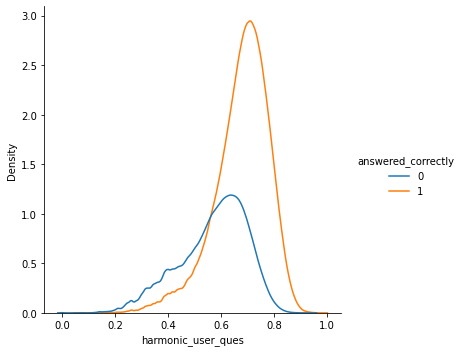

CPU times: user 1min 9s, sys: 11.8 s, total: 1min 21s
Wall time: 1min 19s


In [58]:
%%time
# Plot the distribution of values in column harmonic_user_ques

sns.displot(data=train, x='harmonic_user_ques', hue='answered_correctly', kind='kde')
plt.show()

In [346]:
%%time
# Create the harmonic mean of user_acc and ques_acc

validate['harmonic_user_ques'] = (2*validate.user_acc*validate.ques_acc) / (validate.user_acc + validate.ques_acc)
validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540985 entries, 0 to 2540984
Data columns (total 13 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   answered_correctly              int8   
 1   prior_question_elapsed_time     float32
 2   prior_question_had_explanation  bool   
 3   user_acc                        float32
 4   user_tags_acc                   float32
 5   user_part_acc                   float32
 6   user_tagcount_acc               float32
 7   ques_acc                        float32
 8   bundle_acc                      float32
 9   part_acc                        float32
 10  task_acc                        float32
 11  user_ques_acc                   float32
 12  harmonic_user_ques              float32
dtypes: bool(1), float32(11), int8(1)
memory usage: 130.9 MB
CPU times: user 35.9 ms, sys: 6.45 ms, total: 42.4 ms
Wall time: 18.4 ms


In [347]:
%%time
# Create the harmonic mean of user_acc and ques_acc

test['harmonic_user_ques'] = (2*test.user_acc*test.ques_acc) / (test.user_acc + test.ques_acc)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2644620 entries, 0 to 2644619
Data columns (total 13 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   answered_correctly              int8   
 1   prior_question_elapsed_time     float32
 2   prior_question_had_explanation  bool   
 3   user_acc                        float32
 4   user_tags_acc                   float32
 5   user_part_acc                   float32
 6   user_tagcount_acc               float32
 7   ques_acc                        float32
 8   bundle_acc                      float32
 9   part_acc                        float32
 10  task_acc                        float32
 11  user_ques_acc                   float32
 12  harmonic_user_ques              float32
dtypes: bool(1), float32(11), int8(1)
memory usage: 136.2 MB
CPU times: user 36.3 ms, sys: 7.36 ms, total: 43.6 ms
Wall time: 19.1 ms


### Add new feature - Harmonic mean of user_acc and bundle_acc

In [171]:
%%time
# Create the harmonic mean of user_acc and bundle_acc

train['harmonic_user_bundle'] = (2*train.user_acc*train.bundle_acc) / (train.user_acc + train.bundle_acc)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   answered_correctly              int8   
 1   prior_question_elapsed_time     float32
 2   prior_question_had_explanation  bool   
 3   user_acc                        float32
 4   user_tags_acc                   float32
 5   user_part_acc                   float32
 6   user_tagcount_acc               float32
 7   ques_acc                        float32
 8   bundle_acc                      float32
 9   harmonic_user_bundle            float32
dtypes: bool(1), float32(8), int8(1)
memory usage: 823.3 MB
CPU times: user 335 ms, sys: 532 ms, total: 867 ms
Wall time: 208 ms


In [175]:
validate['harmonic_user_bundle'] = (2*validate.user_acc*validate.bundle_acc) / (validate.user_acc + validate.bundle_acc)
test['harmonic_user_bundle'] = (2*test.user_acc*test.bundle_acc) / (test.user_acc + test.bundle_acc)

### Add new feature - Product of user_acc and part_acc

In [282]:
%%time
# Create the product of user_acc and part_acc

train['product_user_part'] = train.user_acc*train.part_acc
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 12 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   answered_correctly              int8   
 1   prior_question_elapsed_time     float32
 2   prior_question_had_explanation  bool   
 3   user_acc                        float32
 4   user_tags_acc                   float32
 5   user_part_acc                   float32
 6   user_tagcount_acc               float32
 7   ques_acc                        float32
 8   bundle_acc                      float32
 9   part_acc                        float32
 10  harmonic_user_ques              float32
 11  product_user_part               float32
dtypes: bool(1), float32(10), int8(1)
memory usage: 980.1 MB
CPU times: user 97.5 ms, sys: 8.62 ms, total: 106 ms
Wall time: 40.8 ms


In [283]:
validate['product_user_part'] = validate.user_acc*validate.part_acc
test['product_user_part'] = test.user_acc*test.part_acc

### Check the missing values

In [316]:
# Check the missing values in the validate
train.isnull().sum(axis=0)

answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
user_acc                          0
user_tags_acc                     1
user_part_acc                     0
user_tagcount_acc                 0
ques_acc                          0
bundle_acc                        0
part_acc                          0
task_acc                          0
harmonic_user_ques                0
dtype: int64

In [317]:
# Check the missing values in the validate
validate.isnull().sum(axis=0)

answered_correctly                     0
prior_question_elapsed_time            0
prior_question_had_explanation         0
user_acc                               0
user_tags_acc                     757773
user_part_acc                      41473
user_tagcount_acc                  14165
ques_acc                               3
bundle_acc                             3
part_acc                               0
task_acc                            3545
harmonic_user_ques                     3
dtype: int64

In [318]:
# Check the missing values in the validate
test.isnull().sum(axis=0)

answered_correctly                     0
prior_question_elapsed_time            0
prior_question_had_explanation         0
user_acc                               0
user_tags_acc                     831523
user_part_acc                      90722
user_tagcount_acc                  23591
ques_acc                               1
bundle_acc                             1
part_acc                               0
task_acc                           43053
harmonic_user_ques                     1
dtype: int64

### Fill the missing values with 0

In [354]:
train.fillna(0, inplace=True)
validate.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [355]:
# Check the missing values in the validate
train.isnull().sum(axis=0)

answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
user_acc                          0
user_tags_acc                     0
user_part_acc                     0
user_tagcount_acc                 0
ques_acc                          0
bundle_acc                        0
part_acc                          0
task_acc                          0
user_ques_acc                     0
harmonic_user_ques                0
dtype: int64

In [356]:
# Check the missing values in the validate
validate.isnull().sum(axis=0)

answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
user_acc                          0
user_tags_acc                     0
user_part_acc                     0
user_tagcount_acc                 0
ques_acc                          0
bundle_acc                        0
part_acc                          0
task_acc                          0
user_ques_acc                     0
harmonic_user_ques                0
dtype: int64

In [357]:
# Check the missing values in the validate
test.isnull().sum(axis=0)

answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
user_acc                          0
user_tags_acc                     0
user_part_acc                     0
user_tagcount_acc                 0
ques_acc                          0
bundle_acc                        0
part_acc                          0
task_acc                          0
user_ques_acc                     0
harmonic_user_ques                0
dtype: int64

### Combine features user_ques_acc and harmonic_user_ques

In [359]:
train['combo_user_ques_harmonic'] = (train.user_ques_acc + train.harmonic_user_ques)/2
validate['combo_user_ques_harmonic'] = (validate.user_ques_acc + validate.harmonic_user_ques)/2
test['combo_user_ques_harmonic'] = (test.user_ques_acc + test.harmonic_user_ques)/2

### Convert boolean to numeric

In [360]:
%%time
# Convert the boolean values to 1 and 0

train.prior_question_had_explanation = train.prior_question_had_explanation.map({True: 1, False: 0})
validate.prior_question_had_explanation = validate.prior_question_had_explanation.map({True: 1, False: 0})
test.prior_question_had_explanation = test.prior_question_had_explanation.map({True: 1, False: 0})

CPU times: user 1.2 s, sys: 233 ms, total: 1.44 s
Wall time: 1.45 s


In [106]:
# Print 5 random sample of the train dataset
train.sample(5)

,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_acc,user_tags_acc,user_part_acc,user_tagcount_acc,ques_acc,harmonic_user_ques
11338546,0,14000.0,1,0.659,0.00,0.58,0.58,0.41,0.505500
9423012,1,51000.0,1,0.375,1.00,0.40,0.40,0.93,0.534483
9669924,1,30000.0,1,0.798,1.00,0.80,0.80,0.70,0.745794
9087020,1,21000.0,0,0.862,1.00,1.00,0.84,0.36,0.507889
20198255,0,33000.0,1,0.539,0.67,0.58,0.54,0.71,0.612794


**Quick Note**: The mapping change the data type.

In [361]:
%%time
# Cast the int64 to int8

train.prior_question_had_explanation = train.prior_question_had_explanation.astype('int8')
validate.prior_question_had_explanation = validate.prior_question_had_explanation.astype('int8')
test.prior_question_had_explanation = test.prior_question_had_explanation.astype('int8')

CPU times: user 34.2 ms, sys: 16.7 ms, total: 50.9 ms
Wall time: 49.5 ms


In [108]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   answered_correctly              int8   
 1   prior_question_elapsed_time     float32
 2   prior_question_had_explanation  int8   
 3   user_acc                        float32
 4   user_tags_acc                   float32
 5   user_part_acc                   float32
 6   user_tagcount_acc               float32
 7   ques_acc                        float32
 8   harmonic_user_ques              float32
dtypes: float32(7), int8(2)
memory usage: 744.9 MB


### Convert np.inf to 0

In [109]:
def handle_inf(df):
    '''
    This function replaces np.inf values with 0.
    '''
    # Replace questions without an explanation from np.inf to 0.
    m = df.prior_question_elapsed_time.apply(lambda i: 0 if i == np.inf else i)
    df.prior_question_elapsed_time = m
    
    return df

In [362]:
%%time
# Replace the np.inf with 0

train = handle_inf(train)
validate = handle_inf(validate)
test = handle_inf(test)

CPU times: user 6.17 s, sys: 1.44 s, total: 7.61 s
Wall time: 7.77 s


**Quick Note**: The Replacement by lambda function change the data type.

In [363]:
%%time
# Cast the float64 to float32

train.prior_question_elapsed_time = train.prior_question_elapsed_time.astype('float32')
validate.prior_question_elapsed_time = validate.prior_question_elapsed_time.astype('float32')
test.prior_question_elapsed_time = test.prior_question_elapsed_time.astype('float32')

CPU times: user 65 ms, sys: 46.9 ms, total: 112 ms
Wall time: 111 ms


In [364]:
# Print the information of the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 14 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   answered_correctly              int8   
 1   prior_question_elapsed_time     float32
 2   prior_question_had_explanation  int8   
 3   user_acc                        float32
 4   user_tags_acc                   float32
 5   user_part_acc                   float32
 6   user_tagcount_acc               float32
 7   ques_acc                        float32
 8   bundle_acc                      float32
 9   part_acc                        float32
 10  task_acc                        float32
 11  user_ques_acc                   float32
 12  harmonic_user_ques              float32
 13  combo_user_ques_harmonic        float32
dtypes: float32(12), int8(2)
memory usage: 1.1 GB


### Scale the continues variables

In [113]:
def scale(train, validate, test, columns_to_scale):
    '''
    Accepts train, validate, test and list of columns to scale. Scales listed columns.
    '''
    new_column_names = [c + '_scaled' for c in columns_to_scale]
    
    scaler = MinMaxScaler()
    scaler = scaler.fit(train[columns_to_scale])

    train = pd.concat([
        train,
        pd.DataFrame(scaler.transform(train[columns_to_scale]), columns=new_column_names, index=train.index),
    ], axis=1)

    validate = pd.concat([
        validate,
        pd.DataFrame(scaler.transform(validate[columns_to_scale]), columns=new_column_names, index=validate.index),
    ], axis=1)

    test = pd.concat([
        test,
        pd.DataFrame(scaler.transform(test[columns_to_scale]), columns=new_column_names, index=test.index),
    ], axis=1)
    
    train.drop(columns=columns_to_scale, inplace=True)
    validate.drop(columns=columns_to_scale, inplace=True)
    test.drop(columns=columns_to_scale, inplace=True)
    
    return train, validate, test

In [365]:
%%time
# Scale the column prior_question_elapsed_time

columns_to_scale = ['prior_question_elapsed_time']

train, validate, test = scale(train, validate, test, columns_to_scale)

CPU times: user 3 s, sys: 5.11 s, total: 8.1 s
Wall time: 9.65 s


In [290]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 12 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   answered_correctly                  int8   
 1   prior_question_had_explanation      int8   
 2   user_acc                            float32
 3   user_tags_acc                       float32
 4   user_part_acc                       float32
 5   user_tagcount_acc                   float32
 6   ques_acc                            float32
 7   bundle_acc                          float32
 8   part_acc                            float32
 9   harmonic_user_ques                  float32
 10  prior_question_elapsed_time_scaled  float32
 11  product_user_part_scaled            float32
dtypes: float32(10), int8(2)
memory usage: 980.1 MB


**Quick Note**: The scaling doesn't change the data type.

### Final inspection before modeling

In [291]:
# Print the missing values in all columns
train.isnull().sum(axis=0)

answered_correctly                    0
prior_question_had_explanation        0
user_acc                              0
user_tags_acc                         0
user_part_acc                         0
user_tagcount_acc                     0
ques_acc                              0
bundle_acc                            0
part_acc                              0
harmonic_user_ques                    0
prior_question_elapsed_time_scaled    0
product_user_part_scaled              0
dtype: int64

In [366]:
%%time
# Print the descriptive statistics of the train

train.describe()

CPU times: user 6.48 s, sys: 640 ms, total: 7.12 s
Wall time: 7.15 s


,answered_correctly,prior_question_had_explanation,user_acc,user_tags_acc,user_part_acc,user_tagcount_acc,ques_acc,bundle_acc,part_acc,task_acc,user_ques_acc,harmonic_user_ques,combo_user_ques_harmonic,prior_question_elapsed_time_scaled
count,2.055452e+07,2.055452e+07,2.055452e+07,2.055452e+07,2.055452e+07,2.055452e+07,2.055452e+07,2.055452e+07,2.055452e+07,2.055452e+07,2.055452e+07,2.055452e+07,2.055452e+07,2.055452e+07
mean,6.572087e-01,8.910430e-01,7.199415e-01,6.819795e-01,7.269481e-01,7.261035e-01,7.162870e-01,7.170743e-01,6.839503e-01,6.891009e-01,6.527660e-01,6.981177e-01,6.884471e-01,3.431724e-01
std,4.746424e-01,3.115852e-01,1.267456e-01,3.214757e-01,1.587766e-01,1.510102e-01,1.811466e-01,1.629699e-01,5.156527e-02,7.055933e-02,4.090519e-01,1.322861e-01,2.469879e-01,1.871099e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.090000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,6.030000e-01,5.000000e-01,5.900000e-01,5.900000e-01,5.500000e-01,5.630000e-01,6.090000e-01,6.540000e-01,0.000000e+00,5.753589e-01,3.533845e-01,2.290076e-01
50%,1.000000e+00,1.000000e+00,6.750000e-01,6.900000e-01,6.700000e-01,6.700000e-01,6.800000e-01,6.750000e-01,6.710000e-01,6.740000e-01,1.000000e+00,6.612220e-01,7.944038e-01,3.053435e-01
75%,1.000000e+00,1.000000e+00,7.330000e-01,1.000000e+00,7.500000e-01,7.500000e-01,7.900000e-01,7.670000e-01,7.080000e-01,6.880000e-01,1.000000e+00,7.274247e-01,8.570629e-01,4.274809e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.430000e-01,1.000000e+00,1.000000e+00,9.898990e-01,9.949495e-01,1.000000e+00


In [293]:
# Print the missing values in all columns
validate.isnull().sum(axis=0)

answered_correctly                    0
prior_question_had_explanation        0
user_acc                              0
user_tags_acc                         0
user_part_acc                         0
user_tagcount_acc                     0
ques_acc                              0
bundle_acc                            0
part_acc                              0
harmonic_user_ques                    0
prior_question_elapsed_time_scaled    0
product_user_part_scaled              0
dtype: int64

In [294]:
%%time
# Print the descriptive statistics of the validate

validate.describe()

CPU times: user 673 ms, sys: 42.1 ms, total: 715 ms
Wall time: 724 ms


,answered_correctly,prior_question_had_explanation,user_acc,user_tags_acc,user_part_acc,user_tagcount_acc,ques_acc,bundle_acc,part_acc,harmonic_user_ques,prior_question_elapsed_time_scaled,product_user_part_scaled
count,2.540985e+06,2.540985e+06,2.540985e+06,2.540985e+06,2.540985e+06,2.540985e+06,2.540985e+06,2.540985e+06,2.540985e+06,2.540985e+06,2.540985e+06,2.540985e+06
mean,6.724786e-01,9.550556e-01,6.583762e-01,6.028605e-01,6.531753e-01,6.554515e-01,6.617398e-01,6.623788e-01,6.601585e-01,6.431593e-01,3.300237e-01,5.805470e-01
std,4.693093e-01,2.071820e-01,1.127595e-01,2.502336e-01,1.440988e-01,1.380467e-01,1.692327e-01,1.451545e-01,4.606568e-02,1.164485e-01,1.928677e-01,1.088878e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.090000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,6.050000e-01,5.000000e-01,5.800000e-01,5.900000e-01,5.500000e-01,5.730000e-01,6.090000e-01,5.798284e-01,2.137405e-01,5.212975e-01
50%,1.000000e+00,1.000000e+00,6.760000e-01,5.000000e-01,6.700000e-01,6.700000e-01,6.800000e-01,6.760000e-01,6.710000e-01,6.600000e-01,3.053435e-01,5.885088e-01
75%,1.000000e+00,1.000000e+00,7.330000e-01,7.600000e-01,7.500000e-01,7.400000e-01,7.900000e-01,7.630000e-01,6.970000e-01,7.245760e-01,4.198473e-01,6.538412e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.430000e-01,9.795918e-01,1.000000e+00,1.000000e+00


In [295]:
# Print the missing values in all columns
test.isnull().sum(axis=0)

answered_correctly                    0
prior_question_had_explanation        0
user_acc                              0
user_tags_acc                         0
user_part_acc                         0
user_tagcount_acc                     0
ques_acc                              0
bundle_acc                            0
part_acc                              0
harmonic_user_ques                    0
prior_question_elapsed_time_scaled    0
product_user_part_scaled              0
dtype: int64

In [296]:
%%time
# Print the descriptive statistics of the test

test.describe()

CPU times: user 686 ms, sys: 42 ms, total: 728 ms
Wall time: 730 ms


,answered_correctly,prior_question_had_explanation,user_acc,user_tags_acc,user_part_acc,user_tagcount_acc,ques_acc,bundle_acc,part_acc,harmonic_user_ques,prior_question_elapsed_time_scaled,product_user_part_scaled
count,2.644620e+06,2.644620e+06,2.644620e+06,2.644620e+06,2.644620e+06,2.644620e+06,2.644620e+06,2.644620e+06,2.644620e+06,2.644620e+06,2.644620e+06,2.644620e+06
mean,6.582806e-01,9.553811e-01,6.552916e-01,6.012936e-01,6.475030e-01,6.507752e-01,6.582137e-01,6.586559e-01,6.587842e-01,6.393837e-01,3.254983e-01,5.762699e-01
std,4.742861e-01,2.064656e-01,1.153649e-01,2.497668e-01,1.420350e-01,1.402276e-01,1.691552e-01,1.475428e-01,4.628341e-02,1.171600e-01,1.908510e-01,1.106163e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.090000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,6.000000e-01,5.000000e-01,5.700000e-01,5.800000e-01,5.500000e-01,5.660000e-01,6.090000e-01,5.753589e-01,2.137405e-01,5.163795e-01
50%,1.000000e+00,1.000000e+00,6.740000e-01,5.000000e-01,6.600000e-01,6.700000e-01,6.800000e-01,6.730000e-01,6.220000e-01,6.562293e-01,2.900763e-01,5.844105e-01
75%,1.000000e+00,1.000000e+00,7.320000e-01,7.500000e-01,7.400000e-01,7.400000e-01,7.900000e-01,7.620000e-01,6.970000e-01,7.213296e-01,4.122138e-01,6.500000e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.430000e-01,9.688752e-01,1.000000e+00,1.000000e+00


### Modeling - Create X and y

In [376]:
%%time

X_train = train.drop(columns=['answered_correctly', 'user_tags_acc', 'user_part_acc', 
                              'user_tagcount_acc', 'user_acc', 'ques_acc', 'task_acc', 
                              'user_ques_acc', 'combo_user_ques_harmonic'])
y_train = train['answered_correctly']

X_validate = validate.drop(columns=['answered_correctly', 'user_tags_acc', 'user_part_acc', 
                                    'user_tagcount_acc', 'user_acc', 'ques_acc', 'task_acc', 
                                    'user_ques_acc', 'combo_user_ques_harmonic'])
y_validate = validate['answered_correctly']

X_test = test.drop(columns=['answered_correctly', 'user_tags_acc', 'user_part_acc', 
                            'user_tagcount_acc', 'user_acc', 'ques_acc', 'task_acc',
                            'user_ques_acc', 'combo_user_ques_harmonic'])
y_test = test['answered_correctly']

CPU times: user 148 ms, sys: 160 ms, total: 308 ms
Wall time: 404 ms


In [377]:
X_train.head(3)

,prior_question_had_explanation,bundle_acc,part_acc,harmonic_user_ques,prior_question_elapsed_time_scaled
0,0,0.824,0.743,0.411872,0.000000
1,0,0.413,0.743,0.329197,0.366412
2,0,0.359,0.743,0.311811,0.351145


### Modeling - LGBM

In [378]:
%%time

# Create versions of train, validate, and test for lgbm
train_data = lgb.Dataset(X_train, label=y_train)
validate_data = lgb.Dataset(X_validate, label=y_validate)
test_data = lgb.Dataset(X_test, label=y_test)

# Create a list of parameters
params = {'boosting_type': ['gbdt'],
          'objective': ['binary'],
          'nthread': [-1],
          'num_class' :[1],
          'metric' : ['auc'],
          'seed' : [369]}

# Create classifier to use
mdl = lgb.train(params,
                train_data,
                valid_sets=validate_data,
                verbose_eval=100,
                num_boost_round=10_000,
                early_stopping_rounds=10)

[LightGBM] [Info] Number of positive: 13508609, number of negative: 7045910
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 20554519, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.657209 -> initscore=0.650880
[LightGBM] [Info] Start training from score 0.650880
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.744413
[200]	valid_0's auc: 0.744867
[300]	valid_0's auc: 0.745029
[400]	valid_0's auc: 0.745184
[500]	valid_0's auc: 0.745271
[600]	valid_0's auc: 0.745324
[700]	valid_0's auc: 0.74538
[800]	valid_0's auc: 0.745426
[900]	valid_0's auc: 0.745462
Early stopping, best iteration is:
[892]	valid_0's auc: 0.745464
CPU times: user 51min 3s, sys: 40.1 s, t

In [370]:
# Feature Importance
sns.set_context('poster')

lgb.plot_importance(mdl,
                    max_num_features=8,
                    figsize=(12, 8),
                    grid=False,
                    dpi=1000, 
                    importance_type='gain')

plt.grid(axis='x')
plt.title('Feature Importance')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [302]:
%%time

# Display a visual of lgbm decision tree.
lgb.plot_tree(mdl, figsize=(26,26),
              dpi=300,
              tree_index=0,
              show_info ='data_percentage')
plt.show()

CPU times: user 23.9 s, sys: 18.1 s, total: 41.9 s
Wall time: 49.1 s


In [311]:
# Release memory
print("Memory usage before running garbage collector: ", psutil.virtual_memory().percent)
gc.collect
print("Memory usage after: ", psutil.virtual_memory().percent)

Memory usage before running garbage collector:  66.6
Memory usage after:  66.6
